# Combinatorial library vs. ChEMBL

## Aims of this notebook

In this notebook we want to compare the combinatorial library to the ChEMBL 25 dataset.

## Table of contents

1. Combinatorial library data
2. Most similar ChEMBL ligands
3. Exact matches

In [1]:
from pathlib import Path

from chembl_webresource_client.new_client import new_client
import ijson
import matplotlib.pyplot as plt
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

from utils import get_protein_target_classifications

In [2]:
PATH_COMBINATORIAL_LIBRARY = Path('../data/combinatorial_library/combinatorial_library.json')
ACTIVITY_THRESHOLD = 500

## 1. Combinatorial library data

The combinatorial library comes as large JSON file. In order to access/filter ligands efficiently (time and memory), we use the `ijson` library:

> Ijson is an iterative JSON parser with standard Python iterator interfaces.

https://pypi.org/project/ijson/

For a detailed description on the kind of information linked to the combinatorial library, please take a look at the notebook `notebooks/4_1_combinatorial_library_properties.ipynb`.

## 2. Most similar ChEMBL ligands

In [3]:
def similarities_of_most_similar_chembl_ligands(path_json):

    # get object generator from json
    f = open(path_json, 'rb')
    objects = ijson.items(f, 'item')

    # filter objects
    objects_filtered = [o['chembl_most_similar'][1] for o in objects]
    
    return objects_filtered

In [4]:
similarities = similarities_of_most_similar_chembl_ligands(PATH_COMBINATORIAL_LIBRARY)

(array([ 4.,  0.,  2., 10.,  0., 24.,  8., 10.,  0.,  6.]),
 array([0.22 , 0.238, 0.256, 0.274, 0.292, 0.31 , 0.328, 0.346, 0.364,
        0.382, 0.4  ]),
 <a list of 10 Patch objects>)

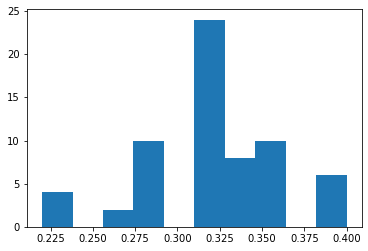

In [5]:
plt.hist(similarities)

## 3. Exact matches

### Get exact matches (including molecule ChEMBL IDs)

In [6]:
def exact_chembl_matches(path_json):

    # get object generator from json
    f = open(path_json, 'rb')
    objects = ijson.items(f, 'item')

    # filter objects
    objects_filtered = [o for o in objects if o['chembl_exact'] != []]
    objects_filtered_df = pd.DataFrame(objects_filtered)
    
    print(f'Number of exact matches in ChEMBL ligands: {objects_filtered_df.shape[0]}')
    
    return objects_filtered_df

In [7]:
exact_matches = exact_chembl_matches(PATH_COMBINATORIAL_LIBRARY)
exact_matches.head()

Number of exact matches in ChEMBL ligands: 0


""


In [8]:
# temporary
f = open(PATH_COMBINATORIAL_LIBRARY, 'rb')
objects = ijson.items(f, 'item')
molecule_ids = [o['chembl_most_similar'][0] for o in objects]

### Get ChEMBL clients and set up filtering documentation

In [9]:
similarity_client = new_client.similarity
molecule_client = new_client.molecule
activity_client = new_client.activity
target_client = new_client.target

In [10]:
def add_filtering_step(filtering, df, step_name):
    
    return filtering.append(
        pd.Series(
            [
                step_name,
                len(df.molecule_chembl_id.unique()),
                len(df.target_chembl_id.unique()),
                len(df.assay_chembl_id.unique()),
                df.shape[0]
            ],
            index=['filtering_step', 'molecules', 'targets', 'assays', 'activities']
        ),
        ignore_index=True
    )

In [11]:
# Initialize filtering table
filtering = pd.DataFrame(columns=['filtering_step', 'molecules', 'targets', 'assays', 'activities'])

### Get molecules (by molecule ChEMBL IDs)

1. Get molecule data from ChEMBL
2. Approved molecules?
3. ATC classified molecules?

#### 1. Get molecule data from ChEMBL

In [12]:
def get_molecules(molecule_ids):
    
    result = molecule_client.get(molecule_ids)
    
    molecules = pd.DataFrame(result)
    molecules = molecules[['molecule_chembl_id', 'molecule_structures', 'first_approval', 'atc_classifications']]
    molecules['smiles'] = molecules.molecule_structures.apply(lambda x: x['canonical_smiles'])
    molecules['inchi'] = molecules.molecule_structures.apply(lambda x: x['standard_inchi'])
    molecules.drop('molecule_structures', axis=1, inplace=True)
    
    print(f'Number of queries: {len(molecule_ids)}')
    print(f'Number of query results: {molecules.shape[0]}')
    
    return molecules

In [13]:
molecules = get_molecules(molecule_ids)

Number of queries: 64
Number of query results: 64


In [14]:
molecules

,molecule_chembl_id,first_approval,atc_classifications,smiles,inchi
0,CHEMBL405398,None,[],Brc1cccc(Nc2ncnc3ccncc23)c1NCCN1CCOCC1,InChI=1S/C19H21BrN6O/c20-15-2-1-3-17(18(15)22-...
1,CHEMBL405398,None,[],Brc1cccc(Nc2ncnc3ccncc23)c1NCCN1CCOCC1,InChI=1S/C19H21BrN6O/c20-15-2-1-3-17(18(15)22-...
2,CHEMBL264472,None,[],Cc1cccc(N2CCN(CCCON3C(=O)c4ccccc4C3=O)CC2)c1,InChI=1S/C22H25N3O3/c1-17-6-4-7-18(16-17)24-13...
3,CHEMBL500021,None,[],CCC(C)CNc1nc(C#N)nc2c1NCN2Cc1ccccc1,InChI=1S/C18H22N6/c1-3-13(2)10-20-17-16-18(23-...
4,CHEMBL405398,None,[],Brc1cccc(Nc2ncnc3ccncc23)c1NCCN1CCOCC1,InChI=1S/C19H21BrN6O/c20-15-2-1-3-17(18(15)22-...
...,...,...,...,...,...
59,CHEMBL266960,None,[],COc1ccc(CNc2nnc(N3CCC(O)CC3)c3ccc(C#N)cc23)cc1Cl,InChI=1S/C22H22ClN5O2/c1-30-20-5-3-15(11-19(20...
60,CHEMBL405398,None,[],Brc1cccc(Nc2ncnc3ccncc23)c1NCCN1CCOCC1,InChI=1S/C19H21BrN6O/c20-15-2-1-3-17(18(15)22-...
61,CHEMBL499520,None,[],O=C(Nc1ncc(F)s1)[C@H](CC1CCOCC1)c1ccc(S(=O)(=O...,InChI=1S/C20H23FN2O4S2/c21-18-12-22-20(28-18)2...
62,CHEMBL266960,None,[],COc1ccc(CNc2nnc(N3CCC(O)CC3)c3ccc(C#N)cc23)cc1Cl,InChI=1S/C22H22ClN5O2/c1-30-20-5-3-15(11-19(20...


#### 2. Approved molecules?

In [15]:
# Check if first_approval field is not empty
molecules[~molecules.first_approval.isna()]

,molecule_chembl_id,first_approval,atc_classifications,smiles,inchi


In [16]:
# Query ChEMBL by `max_phase` field
approved_drugs = molecule_client.filter(molecule_chembl_id__in = list(molecule_ids), max_phase=4)
approved_drugs

[]

#### 3. ATC classified molecules?

In [17]:
# Check if atc classified field is not empty
molecules[molecules.atc_classifications.str.len() != 0]

,molecule_chembl_id,first_approval,atc_classifications,smiles,inchi


### Get molecules with human targets in ChEMBL

1. Get activities (by molecule ChEMBL IDs)
2. Remove activities for non-human target origanisms

#### 1. Get activities (by molecule ChEMBL IDs)

In [18]:
def get_activities(molecule_ids):
    
    activities = activity_client.filter(
        molecule_chembl_id__in=molecule_ids,
        type='IC50', 
        relation='=', 
        assay_type='B'
    ).only(
        'activity_id','assay_chembl_id', 'assay_description', 'assay_type', \
        'molecule_chembl_id', 'type', 'standard_units', 'relation', 'standard_value', \
        'target_chembl_id', 'target_organism', 'target_pref_name'
    )
    
    activities_df = pd.DataFrame.from_records(list(activities))
    activities_df = activities_df.astype({'standard_value': 'float'})
    
    print(f'Number of queries: {len(molecule_ids)}')
    print(f'Number of query results: {activities_df.shape[0]}')
    
    return activities_df

In [19]:
activities = get_activities(molecule_ids)

Number of queries: 64
Number of query results: 2


In [20]:
activities.columns

Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'standard_units', 'standard_value',
       'target_chembl_id', 'target_organism', 'target_pref_name', 'type',
       'units', 'value'],
      dtype='object')

In [21]:
activities

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,target_pref_name,type,units,value
0,589287,CHEMBL762826,Inhibition of Phosphodiesterase 5 from human p...,B,CHEMBL266960,=,nM,0.6,CHEMBL1827,Homo sapiens,Phosphodiesterase 5A,IC50,nM,0.6
1,903916,CHEMBL757897,Inhibition of PDE5 of human platelets,B,CHEMBL266960,=,nM,0.6,CHEMBL1827,Homo sapiens,Phosphodiesterase 5A,IC50,nM,0.6


In [22]:
filtering = add_filtering_step(filtering, activities, 'ChEMBL bioactivity entries')

#### 2. Remove activities for non-human target organisms

In [23]:
activities = activities[activities.target_organism == 'Homo sapiens']
activities.drop('target_organism', axis=1, inplace=True)

In [24]:
filtering = add_filtering_step(filtering, activities, 'Only human entries')
filtering

,filtering_step,molecules,targets,assays,activities
0,ChEMBL bioactivity entries,1,1,2,2
1,Only human entries,1,1,2,2


### Get active molecules (among the exact matches)

1. Look at activities grouped by molecules, targets, and assays
2. Get highest activity (lowest IC50) per molecule-target pair
3. Get molecules that are "active" (<=`ACTIVITY_THRESHOLD` nM) against at least one target

#### 1. Look at activities grouped by molecules, targets, and assays

In [25]:
activities.groupby(
    ['molecule_chembl_id', 'target_chembl_id', 'target_pref_name', 'assay_chembl_id', 'assay_description']
)['standard_value'].apply(list).reset_index()

,molecule_chembl_id,target_chembl_id,target_pref_name,assay_chembl_id,assay_description,standard_value
0,CHEMBL266960,CHEMBL1827,Phosphodiesterase 5A,CHEMBL757897,Inhibition of PDE5 of human platelets,[0.6]
1,CHEMBL266960,CHEMBL1827,Phosphodiesterase 5A,CHEMBL762826,Inhibition of Phosphodiesterase 5 from human p...,[0.6]


#### 2. Get highest activity (lowest IC50) per molecule-target pair

In [26]:
activities_min = activities.sort_values(
    ['molecule_chembl_id', 'target_chembl_id', 'standard_value']
).groupby(
    ['molecule_chembl_id', 'target_chembl_id']
).first().reset_index()

In [27]:
activities_min.head()

,molecule_chembl_id,target_chembl_id,activity_id,assay_chembl_id,assay_description,assay_type,relation,standard_units,standard_value,target_pref_name,type,units,value
0,CHEMBL266960,CHEMBL1827,589287,CHEMBL762826,Inhibition of Phosphodiesterase 5 from human p...,B,=,nM,0.6,Phosphodiesterase 5A,IC50,nM,0.6


#### 3. Get molecules that are "active" (<=`ACTIVITY_THRESHOLD` nM) against at least one target

In [28]:
activities_active = activities_min[activities_min.standard_value <= ACTIVITY_THRESHOLD]
activities_active

,molecule_chembl_id,target_chembl_id,activity_id,assay_chembl_id,assay_description,assay_type,relation,standard_units,standard_value,target_pref_name,type,units,value
0,CHEMBL266960,CHEMBL1827,589287,CHEMBL762826,Inhibition of Phosphodiesterase 5 from human p...,B,=,nM,0.6,Phosphodiesterase 5A,IC50,nM,0.6


In [29]:
filtering = add_filtering_step(filtering, activities_active, 'Only "active" entries')
filtering

,filtering_step,molecules,targets,assays,activities
0,ChEMBL bioactivity entries,1,1,2,2
1,Only human entries,1,1,2,2
2,"Only ""active"" entries",1,1,1,1


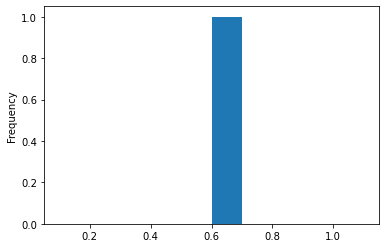

In [30]:
activities_active.standard_value.plot(kind='hist')

### Investigate targets of active molecules

1. Get ChEMBL target details: Protein target classification (PTC)
2. Combine molecule, bioactivity, and target information
3. Get targets per molecule / get molecules per target
4. Add kinase names
5. Show molecules with kinase target

#### 1. Get ChEMBL target details: Protein target classification (PTC)

In order to access the protein target classification, we follow the instructions given here: https://github.com/chembl/chembl_webservices_2/issues/95

In [31]:
target_chembl_ids = list(activities_active.target_chembl_id.unique())
print(len(target_chembl_ids))
target_chembl_ids

1


['CHEMBL1827']

Get PTC for target ChEMBL IDs.

In [32]:
protein_target_classifications = get_protein_target_classifications(target_chembl_ids)

print(f'Number of target ChEMBL IDs: {len(target_chembl_ids)}')
print(f'Number of PTCs: {len(protein_target_classifications.target_chembl_id.unique())}')

protein_target_classifications.head()

Number of target ChEMBL IDs: 1
Number of PTCs: 1


,l1,l2,l3,l4,l5,l6,l7,l8,protein_class_id,target_chembl_id,component_id,protein_classification_id
0,Enzyme,Phosphodiesterase,Phosphodiesterase 5,Phosphodiesterase 5A,None,None,None,None,104,CHEMBL1827,124,104


Show enzyme group distribution.

In [33]:
protein_target_classifications.groupby(by='l2').size()

l2
Phosphodiesterase    1
dtype: int64

#### 2. Combine molecule, bioactivity, and target information

Merge bioactivities and PTC information on target ChEMBL IDs.

In [34]:
molecules_targets_details = pd.merge(
    activities_active, protein_target_classifications, on='target_chembl_id', how='left'
).sort_values(
    by='molecule_chembl_id'
)[['molecule_chembl_id', 'target_chembl_id', 'target_pref_name', 'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'assay_chembl_id', 'assay_description', 'standard_value']]

molecules_targets_details.sort_values(by=['molecule_chembl_id', 'standard_value'], inplace=True)
molecules_targets_details.fillna('Unknown', inplace=True)

print(molecules_targets_details.shape)
molecules_targets_details

(1, 12)


,molecule_chembl_id,target_chembl_id,target_pref_name,l1,l2,l3,l4,l5,l6,assay_chembl_id,assay_description,standard_value
0,CHEMBL266960,CHEMBL1827,Phosphodiesterase 5A,Enzyme,Phosphodiesterase,Phosphodiesterase 5,Phosphodiesterase 5A,Unknown,Unknown,CHEMBL762826,Inhibition of Phosphodiesterase 5 from human p...,0.6


In [35]:
filtering = add_filtering_step(filtering, molecules_targets_details[molecules_targets_details.l2 == 'Kinase'], 'Only kinases')
filtering

,filtering_step,molecules,targets,assays,activities
0,ChEMBL bioactivity entries,1,1,2,2
1,Only human entries,1,1,2,2
2,"Only ""active"" entries",1,1,1,1
3,Only kinases,0,0,0,0


#### 3. Get targets per molecule / get molecules per target

In [36]:
molecules_targets_details.groupby(
    by=['l1', 'l2', 'molecule_chembl_id']
)['target_pref_name'].apply(list)

l1      l2                 molecule_chembl_id
Enzyme  Phosphodiesterase  CHEMBL266960          [Phosphodiesterase 5A]
Name: target_pref_name, dtype: object

In [37]:
molecules_targets_details.groupby(
    by=['molecule_chembl_id', 'l1', 'l2']
)['target_pref_name'].apply(list)

molecule_chembl_id  l1      l2               
CHEMBL266960        Enzyme  Phosphodiesterase    [Phosphodiesterase 5A]
Name: target_pref_name, dtype: object

#### 4. Add kinase names

#### 5. Show molecules with kinase target

### Filtering overview

In [38]:
filtering

,filtering_step,molecules,targets,assays,activities
0,ChEMBL bioactivity entries,1,1,2,2
1,Only human entries,1,1,2,2
2,"Only ""active"" entries",1,1,1,1
3,Only kinases,0,0,0,0
